In [15]:
BATCH_SIZE       = 128
GATE_OPTIMIZER   ='sparsemax'    # Adam LR
GUMBEL_TAU       = 1
GROUP_SUM_TAU    = 30
NETWORK_LAYERS   = 4   # first 784->GATES, then (layers-1) x (G->G) as in notebook spirit
GATES            = 10000
EPOCHS           = 20
ENTMAX_ALPHA = 2
CONNECTIONS = 'random'
LOG_CSV          = "../logs/run_log_connections.csv"
FINAL_STATS_JSON = "final_stats.json"
PLOT_PNG         = "acc_discrete_vs_eval.png"
NETWORK_LR = 0.01

In [16]:
# ==== Imports ====
import os, csv, json, time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from difflogic import LogicLayer, GroupSum
from difflogic.packbitstensor import PackBitsTensor


In [17]:
device = torch.device('cuda')

# ==== Data ====
transform = transforms.Compose([
    transforms.ToTensor()  # notebook uses raw ToTensor
])
train_ds = datasets.MNIST(root='../data', train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [18]:
def build_model():
    layers = [nn.Flatten(),
              LogicLayer(784, GATES, device='cuda', implementation='cuda',
                         gate_function=GATE_OPTIMIZER, 
                         gumbel_tau=GUMBEL_TAU, 
                         connections=CONNECTIONS,
                         entmax_alpha=ENTMAX_ALPHA)]
    for _ in range(NETWORK_LAYERS - 1):
        layers.append(
            LogicLayer(GATES, GATES, device='cuda', implementation='cuda',
                       gate_function=GATE_OPTIMIZER, 
                       gumbel_tau=GUMBEL_TAU, 
                       connections=CONNECTIONS,
                       entmax_alpha=ENTMAX_ALPHA)
        )
    layers.append(GroupSum(10, tau=GROUP_SUM_TAU))
    return nn.Sequential(*layers).to(device)

model = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=NETWORK_LR)

In [19]:
@torch.no_grad()
def eval_accuracy_float(model, loader, mode='eval'):
    """Evaluate with float inputs; compare model.train() vs model.eval() as requested."""
    orig = model.training
    if mode == 'train':
        model.train()
    else:
        model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    model.train(orig)
    return correct / max(1, total)


In [20]:
def packbits_eval(model, loader):
    """Discrete-style eval using PackBitsTensor (as in notebook)."""
    orig_mode = model.training
    start = time.perf_counter()
    with torch.no_grad():
        model.eval()
        res = np.mean([
            (
                model(
                    PackBitsTensor(
                        x.to('cuda').reshape(x.shape[0], -1).round().bool()
                    )
                ).argmax(-1) == y.to('cuda')
            ).to(torch.float32).mean().item()
            for x, y in loader
        ])
    model.train(mode=orig_mode)
    elapsed = time.perf_counter() - start
    throughput = 10_000 / elapsed  # MNIST test set has 10k examples
    print(f"throughput : {throughput:.1f}/s")
    return float(res)


In [21]:
fieldnames = [
    "epoch", "train_loss", "train_acc",
    "float_eval_acc", "float_trainmode_acc", "discrete_acc",
    "BATCH_SIZE", "GATE_OPTIMIZER", "NETWORK_LR", "GUMBEL_TAU",
    "GROUP_SUM_TAU", "NETWORK_LAYERS", "GATES", "EPOCHS", "CONNECTIONS"
]
header_needed = (not os.path.exists(LOG_CSV)) or (os.path.getsize(LOG_CSV) == 0)
with open(LOG_CSV, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if header_needed:
        writer.writeheader()


In [22]:
def change_gate_optimizer(model, new_gate_optimizer,new_noise_temp):
    for module in model.modules():
        if isinstance(module, LogicLayer):
            module.gate_function = new_gate_optimizer
            module.noise_temp = new_noise_temp
            # You may also need to re-initialize related internal parameters or settings if referenced


In [25]:
# Stop training at any epoch
# Change gate optimizer to 'gumbel_softmax', for instance
new_gate_opt = 'sparsemax_noise'
change_gate_optimizer(model, new_gate_opt, 0.5)
GATE_OPTIMIZER   = new_gate_opt
# Resume training as usual


In [ ]:
@torch.no_grad()
def measure_discretization(model):
    """Measure how 'discrete' each layer's gates are"""
    discretization_scores = []
    for layer in model.modules():
        if isinstance(layer, LogicLayer):
            # Compute weights distribution
            if layer.gate_function in ['sparsemax', 'sparsemax_noise']:
                w = sparsemax(layer.weights, dim=-1)
            else:
                w = torch.nn.functional.softmax(layer.weights, dim=-1)
            
            # Max probability across gates (1.0 = fully discrete)
            max_probs = w.max(dim=-1)[0].mean().item()
            discretization_scores.append(max_probs)
    
    return discretization_scores

# In training loop, every epoch:


In [ ]:
eval_acc_hist = []
disc_acc_hist = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    seen = 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        seen += x.size(0)

    train_loss = running_loss / max(1, seen)
    train_acc  = correct / max(1, seen)

    # Float eval in eval-mode vs train-mode
    float_eval_acc       = eval_accuracy_float(model, test_loader, mode='eval')
    float_trainmode_acc  = eval_accuracy_float(model, test_loader, mode='train')

    # Discrete-style accuracy (PackBits)
    discrete_acc = float_eval_acc

    # Print concise progress
    print(f"Epoch {epoch}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
          f"float_train_acc={float_trainmode_acc:.4f} "
          f"discrete_acc={discrete_acc:.4f}")

    # Track for plotting
    eval_acc_hist.append(float_trainmode_acc)
    disc_acc_hist.append(float_eval_acc)

    disc_scores = measure_discretization(model)
    print(f"Layer discretization: {[f'{s:.3f}' for s in disc_scores]}")
    # Log row with hyperparams repeated (simple single-file log)
    with open(LOG_CSV, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow(dict(
            epoch=epoch, train_loss=train_loss, train_acc=train_acc,
            float_eval_acc=float_eval_acc, float_trainmode_acc=float_trainmode_acc,
            discrete_acc=discrete_acc,
            BATCH_SIZE=BATCH_SIZE, GATE_OPTIMIZER=GATE_OPTIMIZER, NETWORK_LR=NETWORK_LR,
            GUMBEL_TAU=GUMBEL_TAU, GROUP_SUM_TAU=GROUP_SUM_TAU,
            NETWORK_LAYERS=NETWORK_LAYERS, GATES=GATES, EPOCHS=EPOCHS, 
            CONNECTIONS=CONNECTIONS
        ))


Epoch 1: train_loss=0.4834 train_acc=0.8894 float_train_acc=0.9138 discrete_acc=0.9159
Epoch 2: train_loss=0.3590 train_acc=0.9097 float_train_acc=0.9214 discrete_acc=0.9208
Epoch 3: train_loss=0.3328 train_acc=0.9159 float_train_acc=0.9233 discrete_acc=0.9237
Epoch 4: train_loss=0.3181 train_acc=0.9189 float_train_acc=0.9253 discrete_acc=0.9258
Epoch 5: train_loss=0.3076 train_acc=0.9222 float_train_acc=0.9293 discrete_acc=0.9290
Epoch 6: train_loss=0.3006 train_acc=0.9247 float_train_acc=0.9301 discrete_acc=0.9298
Epoch 7: train_loss=0.2946 train_acc=0.9262 float_train_acc=0.9294 discrete_acc=0.9327
Epoch 8: train_loss=0.2902 train_acc=0.9275 float_train_acc=0.9319 discrete_acc=0.9321
Epoch 9: train_loss=0.2863 train_acc=0.9280 float_train_acc=0.9306 discrete_acc=0.9323
Epoch 10: train_loss=0.2834 train_acc=0.9290 float_train_acc=0.9319 discrete_acc=0.9322
Epoch 11: train_loss=0.2805 train_acc=0.9299 float_train_acc=0.9322 discrete_acc=0.9329
Epoch 12: train_loss=0.2786 train_acc=0.9

Exception in thread Thread-70 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/ramganeshs/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ramganeshs/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in _pin_memory_loop
    do_one_step()
  File "/home/ramganeshs/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 32, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ramganeshs/.venv/lib/python3.12/si

KeyboardInterrupt: 

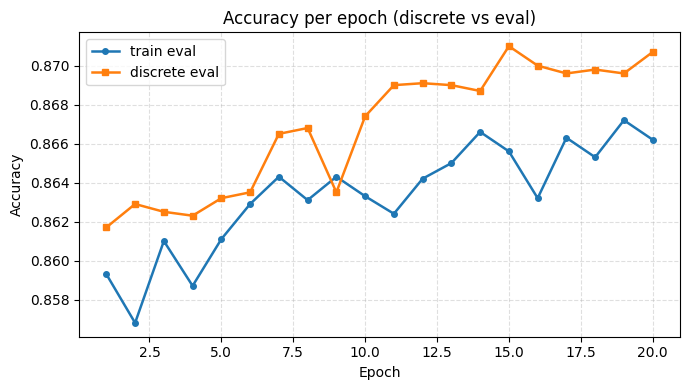

In [23]:
# ==== Plot: discrete vs eval accuracy ====
plt.figure(figsize=(7, 4))
steps = np.arange(1, len(eval_acc_hist) + 1)
plt.plot(steps, eval_acc_hist, marker='o', linewidth=1.8, markersize=4, label='train eval')
plt.plot(steps, disc_acc_hist, marker='s', linewidth=1.8, markersize=4, label='discrete eval')
plt.title('Accuracy per epoch (discrete vs eval)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_PNG, dpi=150)
plt.show()


In [ ]:
# ==== Hyperparameters (minimal, aligned with notebook) ====


# ==== Device (match notebook: CUDA logic layers) ====

# ==== Model (stay in-line with difflogic notebook pattern) ====


# ==== Utilities (match/extend notebook evaluation) ====


# ==== Logging setup ====



# ==== Save final stats ====
final_stats = dict(
    final_epoch=EPOCHS,
    final_train_loss=train_loss,
    final_train_acc=train_acc,
    final_float_eval_acc=eval_acc_hist[-1],
    final_discrete_acc=disc_acc_hist[-1],
    hyperparams=dict(
        BATCH_SIZE=BATCH_SIZE,
        GATE_OPTIMIZER=GATE_OPTIMIZER,
        NETWORK_LR=NETWORK_LR,
        GUMBEL_TAU=GUMBEL_TAU,
        GROUP_SUM_TAU=GROUP_SUM_TAU,
        NETWORK_LAYERS=NETWORK_LAYERS,
        GATES=GATES,
        EPOCHS=EPOCHS,
    ),
    log_csv=LOG_CSV,
    acc_plot=PLOT_PNG,
)
with open(FINAL_STATS_JSON, "w") as f:
    json.dump(final_stats, f, indent=2)
print(f"Saved final stats to {FINAL_STATS_JSON}")
